In [4]:
!pip install gdown

Defaulting to user installation because normal site-packages is not writeable


In [5]:
# @title Download MoNuSeg Training Data and Convert Masks
import gdown
import os
from PIL import Image
import numpy as np
import xml.etree.ElementTree as ET
from skimage.draw import polygon

def parse_xml_to_mask(xml_path, image_size):

  width, height = image_size
  mask = np.zeros((height, width), dtype=np.uint8)

  tree = ET.parse(xml_path)
  root = tree.getroot()

  for region in root.findall('.//Region'):
    for vertices in region.findall('.//Vertices'):
      row_cords = []
      col_cords = []
      for vertex in vertices.findall('.//Vertex'):
        x = float(vertex.get('X'))
        y = float(vertex.get('Y'))

        row_cords.append(y)
        col_cords.append(x)

      rr, cc = polygon(row_cords, col_cords, (height, width))
      mask[rr, cc] = 1

  return mask

if not os.path.exists('MoNuSeg'):
  # -c to skip if already downloaded. MoNuSeg is hosted on google drive
  gdown.download(id = "1ZgqFJomqQGNnsx7w7QBzQQMVA16lbVCA", output = "MoNuSeg.zip")
  !unzip MoNuSeg.zip -d MoNuSeg
  !rm MoNuSeg.zip

  os.mkdir('MoNuSeg/MoNuSeg 2018 Training Data/Proccessed Annotations')
  os.mkdir('MoNuSeg/MoNuSeg 2018 Training Data/Proccessed Images')

  # Convert masks to 1,000 by 1,000 px pngs
  for file in os.listdir('MoNuSeg/MoNuSeg 2018 Training Data/Annotations'):
    if file.endswith('.xml'):
      xml_path = os.path.join('MoNuSeg/MoNuSeg 2018 Training Data/Annotations', file)
      mask = parse_xml_to_mask(xml_path, (1000, 1000))
      mask = Image.fromarray(mask)
      mask.save(os.path.join('MoNuSeg/MoNuSeg 2018 Training Data/Proccessed Annotations', file[:-4] + '.png'))
  # Convert compressed tiff to png for faster loading
  for file in os.listdir('MoNuSeg/MoNuSeg 2018 Training Data/Tissue Images'):
    if file.endswith('.tif'):
      img_path = os.path.join('MoNuSeg/MoNuSeg 2018 Training Data/Tissue Images', file)
      img = Image.open(img_path)
      img.save(os.path.join('MoNuSeg/MoNuSeg 2018 Training Data/Proccessed Images', file[:-4] + '.png'))

else:
  print("MoNuSeg Training Data already downloaded")

MoNuSeg Training Data already downloaded


In [88]:
# @title MoNuSeg Data Set
from torch.utils.data import Dataset
from PIL import Image
from torchvision.transforms import v2
from torchvision import tv_tensors


class MoNuSegDataset(Dataset):
  def __init__(self, root_dir, transform = None):
    """
    Args:
        root_dir (string): Directory with all the images and masks.
        transform (callable, optional): Optional transform to be applied
            on a sample. Default is random 256x256 crop.
    """
    self.root_dir = root_dir
    self.image_dir = os.path.join(root_dir, 'Proccessed Images')
    self.mask_dir = os.path.join(root_dir, 'Proccessed Annotations')

    # transform both img and mask for data augmentation
    if transform is None:
      transform = v2.RandomCrop((256,256))
    
    self.transform = transform

    # setting up data type
    self.img_transform = v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])

    # Sort to ensure images and masks match
    self.images = sorted(os.listdir(self.image_dir))
    self.masks = sorted(os.listdir(self.mask_dir))

  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):
    img = Image.open(os.path.join(self.image_dir, self.images[idx]))
    mask = Image.open(os.path.join(self.mask_dir, self.masks[idx]))

    # manual transform each for image and mask separately
    img = self.img_transform(img)
    mask = tv_tensors.Mask(mask)
    
    img, mask = self.transform(img, mask)

    mask = mask.squeeze(0) # Remove the channel dimension. It's a channel size of 1 anyway

    return {"image": img, "mask": mask}

In [89]:
# @title Create Dataloader
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

dataset = MoNuSegDataset('MoNuSeg/MoNuSeg 2018 Training Data')

# Pin memory to speed up loading to GPU. Increase # workers
dataloader = DataLoader(dataset, batch_size=8, shuffle=True, pin_memory=True, num_workers=2)

Number of train samples: 37


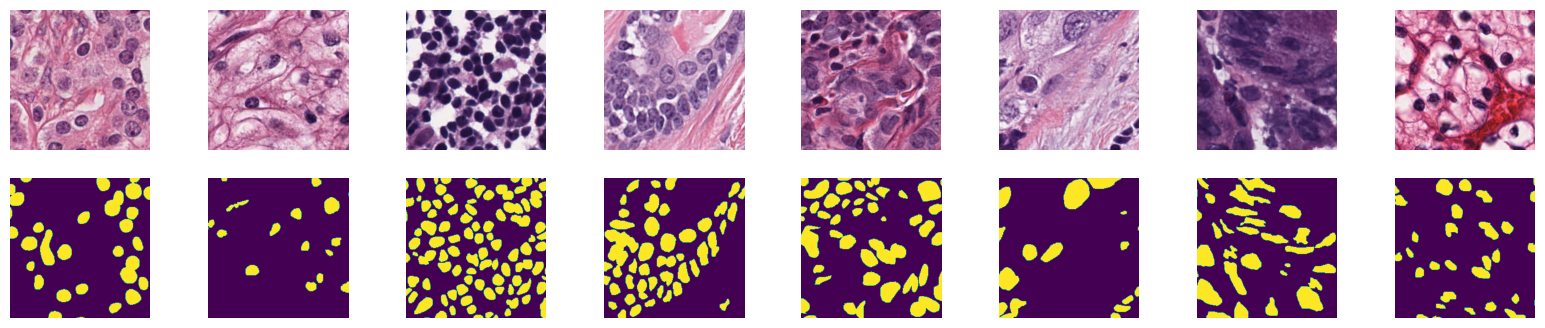

In [91]:
# @title Visualize Batch

images = next(iter(dataloader))

print(f"Number of train samples: {len(dataset)}")

fig, axes = plt.subplots(2, 8, figsize=(20, 4))
for i in range(8):
  axes[0,i].imshow(images["image"][i].permute(1, 2, 0))
  axes[0,i].axis('off')
  axes[1,i].imshow(images["mask"][i])
  axes[1,i].axis('off')

plt.show()

In [92]:
import torch

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda


In [93]:
# @title Define the UNet

import torch
import torch.nn as nn

class ContractingBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ContractingBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding='same')
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding='same')
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        pooled_x = self.pool(x)

        return pooled_x, x # need to return both pooled and pre-pooled for skip connections

class ExpansiveBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ExpansiveBlock, self).__init__()
        self.up_conv = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding='same')
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding='same')

    def forward(self, pooled_x, pre_x):
        pooled_x = self.up_conv(pooled_x)

        diff_Y = pre_x.size()[2] - pooled_x.size()[2]
        diff_X = pre_x.size()[3] - pooled_x.size()[3]
        x_cropped = pre_x[:, :, diff_Y // 2 : pre_x.size()[2] - diff_Y // 2,
                                    diff_X // 2 : pre_x.size()[3] - diff_X // 2]

        x = torch.cat([pooled_x, x_cropped], dim=1) # add across the channel dimensions to double the channel count

        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)

        return x
        

class UNet(nn.Module):
    def __init__(self, num_classes = 2):
        super(UNet, self).__init__()

        # Contracting Path
        self.contract1 = ContractingBlock(3, 64)
        self.contract2 = ContractingBlock(64, 128)
        self.contract3 = ContractingBlock(128, 256)
        self.contract4 = ContractingBlock(256, 512)

        # Bottleneck Layer
        self.bottleneck = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.Conv2d(1024, 1024, kernel_size=3, padding='same'),
            nn.ReLU()             
        )
        
        # Expansive Path
        self.expand1 = ExpansiveBlock(1024, 512)
        self.expand2 = ExpansiveBlock(512, 256)
        self.expand3 = ExpansiveBlock(256, 128)
        self.expand4 = ExpansiveBlock(128, 64)

        # Final layer
        self.final_conv = nn.Conv2d(64, num_classes, kernel_size=1, stride=1, padding='same')

    def forward(self, x):
        x, x_skip1 = self.contract1(x)
        x, x_skip2 = self.contract2(x)
        x, x_skip3 = self.contract3(x)
        x, x_skip4 = self.contract4(x)

        x = self.bottleneck(x)

        x = self.expand1(x, x_skip4)
        x = self.expand2(x, x_skip3)
        x = self.expand3(x, x_skip2)
        x = self.expand4(x, x_skip1)

        x = self.final_conv(x)
        
        return x


In [94]:
# @title Initialize Model (Untrained Model)

untrained_model = UNet()

# optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [95]:
# @title Run on Samples

output = untrained_model(images['image'])

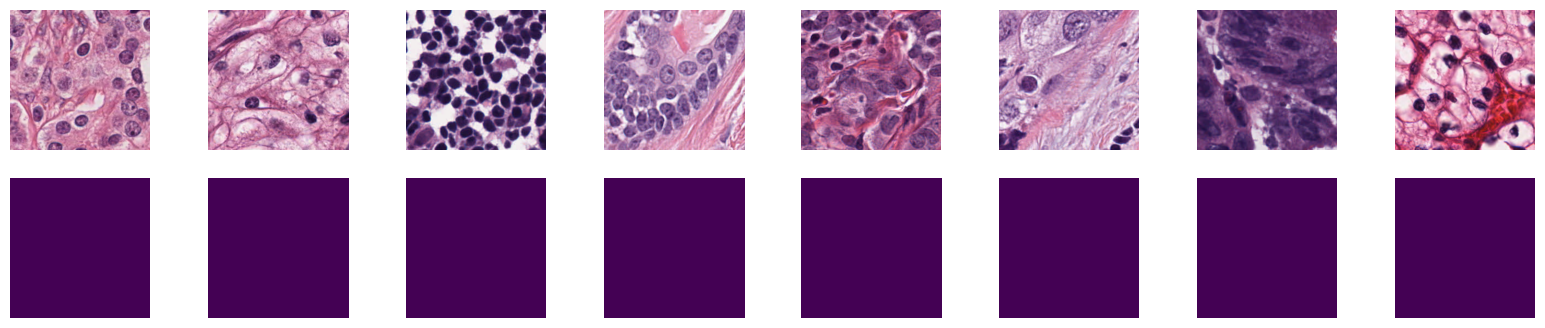

In [96]:
# @title Visualize First Batch Output (No training)
out_mask = (torch.softmax(output, dim = 1)[:,1,:,:].detach() > .5).float()

fig, axes = plt.subplots(2, 8, figsize=(20, 4))
for i in range(8):
  axes[0,i].imshow(images["image"][i].permute(1, 2, 0))
  axes[0,i].axis('off')
  axes[1,i].imshow(out_mask[i])
  axes[1,i].axis('off')

plt.show()

In [104]:
# @title Create a New Instance of Model to train
import torch.nn.functional as F
import torch.optim as optim

model = UNet()

dataloader = DataLoader(dataset, batch_size=8, shuffle=True, pin_memory=True, num_workers=2)

epochs = 10
optimizer = optim.Adam(model.parameters(), lr=1e-3)

model = model.to(device=device)

for epoch in range(epochs):
    for batch in dataloader:
        model.train()
        img = batch['image'].to(device=device, dtype=torch.float32)
        mask = batch['mask'].to(device=device, dtype=torch.int64)

        predicted_mask = model(img)

        loss = F.cross_entropy(predicted_mask, mask)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()
        

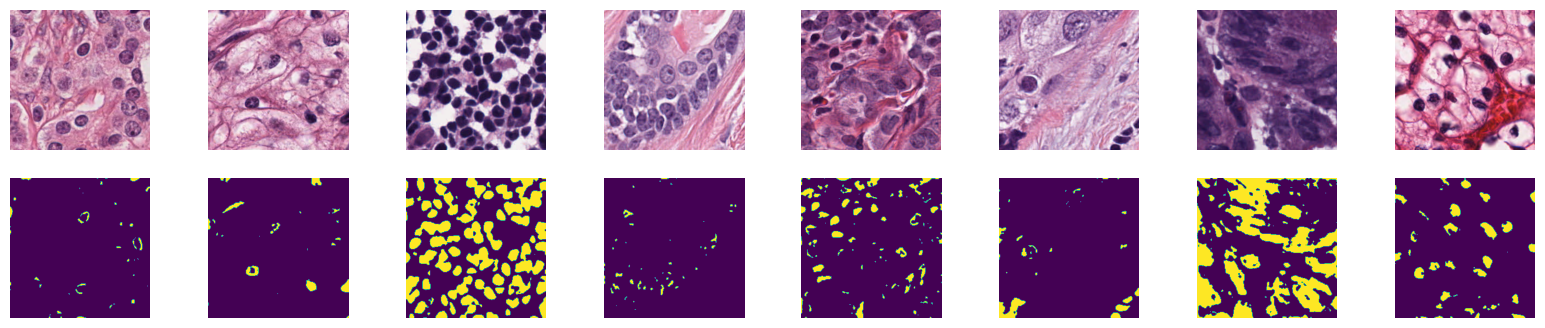

In [105]:
# @title Visualize After 1 Epoch

model.eval()

output_trained = model(images['image'].to(device=device))

out_mask_trained = (torch.softmax(output_trained, dim = 1)[:,1,:,:].cpu() > .5).float()

fig, axes = plt.subplots(2, 8, figsize=(20, 4))
for i in range(8):
  axes[0,i].imshow(images["image"][i].permute(1, 2, 0))
  axes[0,i].axis('off')
  axes[1,i].imshow(out_mask_trained[i])
  axes[1,i].axis('off')

plt.show()